<a href="https://colab.research.google.com/github/SohamK2111/Reply-Hackathon/blob/main/Masked_inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade diffusers transformers accelerate scipy ftfy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 KB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 103.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.6 MB/s eta 0:00:00


You need to accept the model license before downloading or using the weights. In this post we'll use model version `v1-4`, so you'll need to  visit [its card](https://huggingface.co/CompVis/stable-diffusion-v1-4), read the license and tick the checkbox if you agree. 

You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work. For more information on access tokens, please refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

# Imports

In [ ]:
import PIL
import requests
import torch
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import GaussianBlur

from diffusers import StableDiffusionInpaintPipeline

# Pipeline

In [ ]:
device = 'cuda'

pipe = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16)
pipe = pipe.to(device)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [ ]:
def download_image(url, rgb):
    response = requests.get(url)
    if rgb:
      return PIL.Image.open(BytesIO(response.content)).convert("RGB")
    else:
      return PIL.Image.open(BytesIO(response.content))

# Prep vespa image and mask

In [ ]:
vespa_url = "https://images.piaggio.com/vespa/vehicles/evpv000hg1/evpvlfnhg1/evpvlfnhg1-02-s.png"

In [ ]:
vespa_init_image = download_image(vespa_url, rgb=False).resize((512, 512))

In [ ]:
img2_grayscale = vespa_init_image.convert('L')
img2_a = np.array(img2_grayscale)

threshold = 1

mask = np.array(img2_grayscale)
mask[img2_a<threshold] = 0  # This is the area that will get painted, will show up as grey.
mask[img2_a>=threshold] = 1 # This is the protected area, will show up white. Protected areas won't be affected by our generating.

strength = 0.99  # This controls the strength of our prompt relative to the init image.

d = int(255 * (1-strength))
mask *= 255-d # Converts our range from [0,1] to [0,255]
mask += d

mask_image = PIL.ImageOps.invert(PIL.Image.fromarray(mask))

blur = GaussianBlur(1,5)
vespa_mask_image = blur(mask_image)

# Apply in-painting

### Vespa

  0%|          | 0/500 [00:00<?, ?it/s]

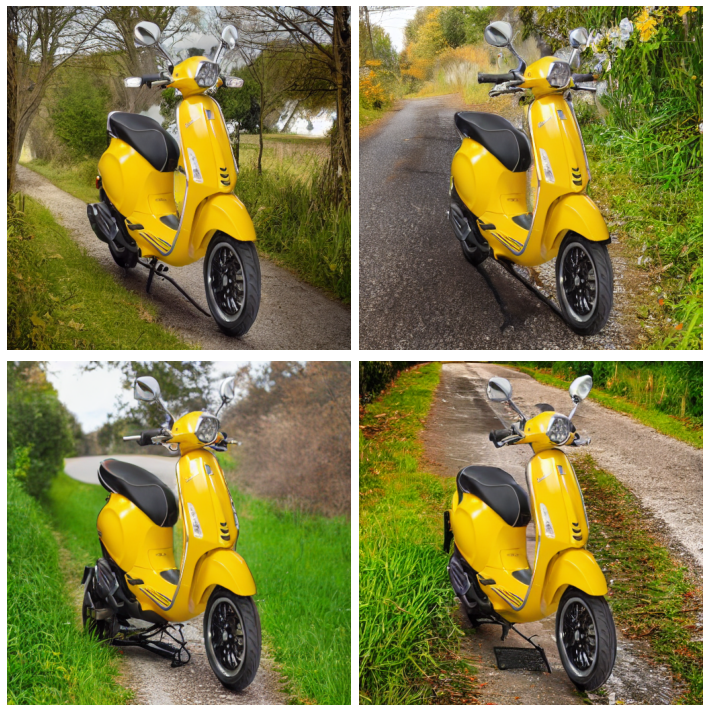

In [ ]:
prompt = "a scooter on a country lane"
image = pipe(prompt=prompt,
             image=vespa_init_image,
             mask_image=vespa_mask_image,
             num_inference_steps=500,
             num_images_per_prompt=4)[0]


fig,ax = plt.subplots(2,2, figsize=(10, 10))

ax[0,0].imshow(image[0])
ax[0,0].axis('off')
ax[0,1].imshow(image[1])
ax[0,1].axis('off')
ax[1,0].imshow(image[2])
ax[1,0].axis('off')
ax[1,1].imshow(image[3])
ax[1,1].axis('off')

plt.tight_layout()